## Exercises
Using the diabetes data set:

## 1. 


from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)


### 1. Nested cross-validation of regularized models with parameter search vs. manual feature selection (2.5p)
In the code above we checked the MSE of the best results from the grid search CV. The models are comparable because the default CV (*sklearn.model_selection.KFold*) is not randomized. 

However, we didn't compute a proper test error of the regularized models including the grid search. Previously we did the train-test split and performed CV based grid search on the training data, 
but when the differences are small and the model is not well suited to the task (we have a lot of unexplained variance) we should get a better estimate of the test error. 

To do this we can use cross validation and tune the parameters independently within each fold, better yet we can do repeat the 'outer' CV and randomize the order of the data for each repeat such that the folds are different.

If this sounds complicated, dont worry: *sklearn* has built-in 'Pipelines' which include a *GridSearchCV* in the estimators. E.g. using *LassoCV* and *RepeatedKFold* in *cross_val_score* performs repeated nested cross-validation with *Lasso*.

There is a code cell below that produces the repeated nested cross-validation RMSE results of a Lasso model (expand the cell), you can try to do it yourself if you want more challenge.

Print the mean and standard deviation of RMSE.

Try *RidgeCV* and *ElasticNetCV* as well.

Choose a set of features that are the most important in your opinion based on the coefficients in the notebook. Use repeated cross-validation to estimate the RMSE of a standard linear model fit on just those features.

Comment on the results. Can you confidently say what is the best model? Would you expect the unregularized model to perform better than the regularized one if you selected the 'true' causal features? 

#### Solution:


In [1]:
import numpy as np
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV

my_seed = 0
alphas = np.logspace(-3,0,31)

lasso_rmse = cross_val_score(LassoCV(alphas = alphas), diabetes.data, diabetes.target, scoring='neg_root_mean_squared_error', cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = my_seed))
print('RMSE mean: {}'.format(-lasso_rmse.mean()))
print('RMSE std: {}'.format(lasso_rmse.std()))

RMSE mean: 54.74798096539705
RMSE std: 5.61639849188746


In [3]:
from sklearn.linear_model import LinearRegression
features = np.array([1,2,3,6,8])
manual_rmse = cross_val_score(LinearRegression(), diabetes.data[:,features], diabetes.target, scoring='neg_root_mean_squared_error', cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = my_seed))
print('RMSE mean: {}'.format(-manual_rmse.mean()))
print('RMSE std: {}'.format(manual_rmse.std()))

RMSE mean: 54.46184569303728
RMSE std: 5.4776698036664655


In [4]:
from sklearn.linear_model import RidgeCV

ridge_rmse = cross_val_score(RidgeCV(alphas = alphas), diabetes.data, diabetes.target, scoring='neg_root_mean_squared_error', cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = my_seed))
print('RMSE mean: {}'.format(-ridge_rmse.mean()))
print('RMSE std: {}'.format(ridge_rmse.std()))

RMSE mean: 54.72881492615611
RMSE std: 5.642576572969555


In [5]:
from sklearn.linear_model import ElasticNetCV

elastic_rmse = cross_val_score(ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], alphas = alphas), diabetes.data, diabetes.target, scoring='neg_root_mean_squared_error', cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = my_seed))
print('RMSE mean: {}'.format(-elastic_rmse.mean()))
print('RMSE std: {}'.format(elastic_rmse.std()))

RMSE mean: 54.75542875076383
RMSE std: 5.592439276053758


Manual selection was slightly better, but the standard deviation of the RMSE is very high comparatively so the models can be expected to perform very similarly on unseen data. We could use more repeats to get a stable enough estimate with low enough standard error to make a statistical judgement, but it in practice the differences are too small to matter. 

Probably, the 'true' unregularized model would outperform since regularization penalizes all coefficients similarly which could pull the true coefficients away from optimum. Although, if we use the regularized model on the 'true' features only, performing a parameter search for alpha we might find that a low alpha value works best giving us almost the same model.

**Note that nested CV is computationally expensive and usually unnecessary, but in this case the differences between the models were so small compared to the unexplained variance that using cross-validation for test accuracy was necessary AND selecting the hyper-parameters using the sklearn EstimatorCV functions is pretty painless AND in the case of linear models it is also computationally relatively inexpensive. CV is a generic tool to implement the train-test(/validation) split robustly and it can be used in a nested setup like this.**

### 2. Polynomial Ridge Regression (2.5p)
We can use the linear regression model to do different tasks (such as logistic regression which we used for classification). In addition to modifying the target, we can modify the features we use in the regression. 

One very interesting modification is polynomial regression. We can use our observations of $x_1$ and $x_2$ to generate the observations of ${x_1}^2$ ${x_2}^2$ and $x_1 \cdot x_2$ and so on. The latter terms are called 'interactions' and they can certainly be interesting in omics data, although for $m$ features you already get $m^2 - m$ interaction terms of degree 2 which quickly leads to problems such as overfitting. We can use the generated 'observations' of these variables as features in e.g. linear regression without changing anything else. We can even use the Ridge regularized model to deal with the overfitting issues (Lasso and ElasticNet don't work so well however).

Use the [*PolynomialFeatures*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomial%20features) to transform the features and estimate the test RMSE of a Ridge regression model on the transformed features. You can use alpha=0.01 and degree = 2.

Fit the polynomial Ridge model on the whole data set and plot the coefficients (e.g. sns.barplot(x=coefficients, y=feature_names)). You can get the polynomial feature names with the get_feature_names method of *PolynomialFeatures*.

Comment on the fit. (Do you think the added complexity justifies the reduction in error over the linear models?)

#### Solution:


In [6]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score

poly = PolynomialFeatures(2)
poly.fit(diabetes.data)
X_poly = poly.transform(diabetes.data)

In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold

ridge_poly_rmse = cross_val_score(Ridge(alpha = 0.01), X_poly, diabetes.target, scoring='neg_root_mean_squared_error', cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = my_seed))

In [8]:
print('RMSE mean: {}'.format(-ridge_poly_rmse.mean()))
print('RMSE std: {}'.format(ridge_poly_rmse.std()))

RMSE mean: 54.042426115843064
RMSE std: 5.628682828019515


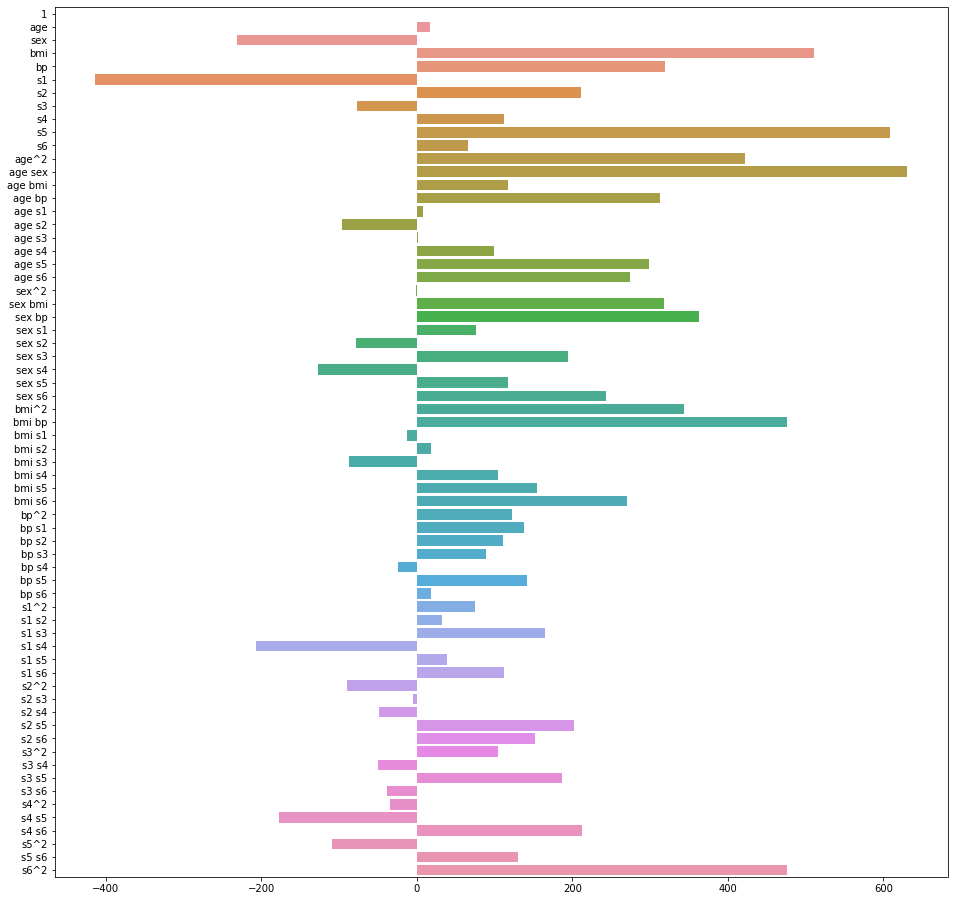

In [9]:
ridge_poly = Ridge(alpha = 0.01).fit(X_poly, diabetes.target)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
ax = sns.barplot(y = poly.get_feature_names(diabetes.feature_names), x = ridge_poly.coef_)
#for item in ax.get_xticklabels():
#    item.set_rotation(90)
plt.show()

The RMSE improvement compared to the linear models is very small and the coefficients for many polynomial features are non-zero which suggests high complexity. Hence the basic linear model seems more reasonable for predicting and explaining diabetes risk.